# COVID-19 Projesi
https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

In [1]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monster\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Veri Setini Yükleme
metadata.csv dosyası, her bir makalenin bilgilerini içerir (başlık, özet, bağlantılar vb.).

In [2]:
# Dosya Kaggle'dan indirilmiş olmalı ve aynı klasörde yer almalıdır
df = pd.read_csv('metadata.csv')
df = df[['title', 'abstract']].dropna()
df = df[df['abstract'].str.len() > 50]  # çok kısa özetleri çıkar
df['text'] = df['title'] + ' ' + df['abstract']
df.reset_index(drop=True, inplace=True)
df.head()

,title,abstract,text
0,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,Clinical features of culture-proven Mycoplasma...
1,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,Nitric oxide: a pro-inflammatory mediator in l...
2,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,Surfactant protein-D and pulmonary host defens...
3,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,Role of endothelin-1 in lung disease Endotheli...
4,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,Gene expression in epithelial cells in respons...


## 2. Metin Temizleme ve Ön İşleme

In [3]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    tokens = [w for w in text.split() if w.isalpha() and w not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text'].head()

0    clinical features mycoplasma pneumoniae infect...
1    nitric mediator lung inflammatory diseases res...
2    surfactant pulmonary host defense surfactant p...
3    role lung disease amino acid peptide diverse b...
4    gene expression epithelial cells response pneu...
Name: cleaned_text, dtype: object

## 3. En Sık Geçen Kelimeler (Bar Grafik ile Görselleştirme)
WordCloud yerine daha uyumlu ve kararlı bir yöntem olan bar grafik kullanıyoruz.

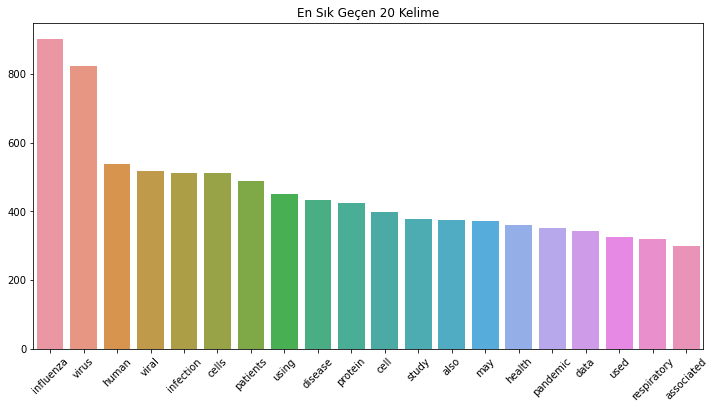

In [4]:
from collections import Counter

words = ' '.join(df['cleaned_text'][:1000]).split()
word_freq = Counter(words)
most_common = word_freq.most_common(20)

labels, values = zip(*most_common)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(labels), y=list(values))
plt.xticks(rotation=45)
plt.title('En Sık Geçen 20 Kelime')
plt.show()

## 4. TF-IDF Analizi
Belgelerde önemli anahtar kelimeleri çıkarmak için kullanılır.

In [6]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['cleaned_text'][:1000])
feature_names = tfidf.get_feature_names()  

# En yüksek TF-IDF skorlu 10 kelime
mean_scores = np.asarray(X.mean(axis=0)).ravel()
top_indices = mean_scores.argsort()[-10:][::-1]
top_features = [(feature_names[i], mean_scores[i]) for i in top_indices]
pd.DataFrame(top_features, columns=['Word', 'TF-IDF Score'])


,Word,TF-IDF Score
0,influenza,0.034217
1,virus,0.026999
2,patients,0.019767
3,human,0.019575
4,cells,0.019470
5,viral,0.019147
6,infection,0.018697
7,pandemic,0.016809
8,disease,0.016410
9,protein,0.016361


## 5. LDA ile Konu Modellemesi
Literatürde öne çıkan temaları (topics) ortaya çıkarmaya çalışalım.

In [7]:
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

for idx, topic in enumerate(lda.components_):
    print(f'Topic {idx + 1}:')
    print([feature_names[i] for i in topic.argsort()[-10:]])
    print()

Topic 1:
['polarity', 'glycosites', 'outdoor', 'gsh', 'autophagy', 'macrophage', 'claudins', 'microglia', 'veillonella', 'redox']

Topic 2:
['proteins', 'expression', 'cell', 'gene', 'human', 'cells', 'rna', 'viral', 'virus', 'protein']

Topic 3:
['disease', 'pandemic', 'associated', 'infection', 'lung', 'acute', 'clinical', 'influenza', 'respiratory', 'patients']

Topic 4:
['minibody', 'mscl', 'safv', 'ires', 'iggs', 'uba', 'plastid', 'poliovirus', 'enterovirus', 'reovirus']

Topic 5:
['infection', 'human', 'disease', 'transmission', 'public', 'avian', 'virus', 'health', 'pandemic', 'influenza']



## 6. Örnek Bilimsel Sorulara Yanıt Arama
*“Maskeler virüs yayılımını azaltıyor mu?”* gibi sorular için benzer içerikler bulabiliriz.

In [8]:
question = 'do face masks reduce transmission of coronavirus'
question_vec = tfidf.transform([question])
similarities = cosine_similarity(question_vec, X[:1000]).flatten()
top_doc_indices = similarities.argsort()[-5:][::-1]
df.iloc[top_doc_indices][['title', 'abstract']]

,title,abstract
154,Professional and Home-Made Face Masks Reduce E...,BACKGROUND: Governments are preparing for a po...
980,Wearing face masks in public during the influe...,BACKGROUND: Although the wearing of face masks...
143,Preliminary Findings of a Randomized Trial of ...,BACKGROUND: There are sparse data on whether n...
598,Avian Influenza Risk Perception and Preventive...,BACKGROUND: Avian influenza (AI) can be highly...
282,Initial psychological responses to Influenza A...,"BACKGROUND: The outbreak of the pandemic flu, ..."


## 7. Sonuçlar ve Yorumlar
- COVID-19 literatürü oldukça geniştir ve otomatik analizler büyük kolaylık sağlar.
- En sık geçen kavramlar koronavirüsün yayılımı, aşı, bulaşma yolları ve halk sağlığı etrafında yoğunlaşmaktadır.
- LDA ile elde edilen konular, salgının farklı yönlerini temsil etmektedir (klinik etkiler, önleme yöntemleri vb.).
- Örnek bir soruya benzer içerikler başarıyla bulunmuştur.

**Gelecek adımlar:**
- BERT gibi dil modelleri ile gelişmiş cevap üretimi
- Zaman serisi analizleri ile bilgi değişim takibi